In [40]:
import sys
!{sys.executable} -m pip install yfinance pandas openpyxl
!{sys.executable} -m pip install linearmodels

1331.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1337.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [41]:
import sys
!{sys.executable} -m pip install lxml


1342.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [42]:
import lxml
print("lxml OK ✅")


lxml OK ✅


In [43]:
# =========================
# 0) INSTALL (notebook Python)
# =========================
import sys
!{sys.executable} -m pip install -q pandas openpyxl requests yfinance

# =========================
# 1) IMPORTS
# =========================
import time
import requests
import pandas as pd
import yfinance as yf
from pathlib import Path

# =========================
# 2) PARAMETERS
# =========================
# ~100 staples / staples-adjacent candidates to maximize usable firms
TICKERS = [
    # Core staples
    "PG","KO","PEP","PM","MO","MDLZ","CL","KMB","GIS","HSY","KHC","MKC","CPB","CAG","HRL","TSN","SJM","CLX",
    "K","TAP","STZ","KDP","MNST","CHD","NWL","EL","COTY",
    # Retail / grocery / distributors (staples-ish)
    "WMT","COST","TGT","KR","DG","DLTR","WBA","ACI","BJ","SFM","IMKTA","WMK","SPTN","UNFI","USFD","PFGC","SYY",
    # Agriculture / ingredients / food supply chain
    "ADM","BG","DAR","ANDE","FDP","INGR","CALM","LW","FLO","POST","THS","LANC","VITL","PPC",
    # Beverages / snack / food names (some may be borderline; included to increase pool)
    "SAM","FIZZ","CELH","UTZ","JJSF","CVGW","SENEA","SENEB","HAIN","NOMD","SMPL","GO","BRBR","NTRI","CHEF","USNA",
    # Tobacco / nicotine / related
    "UVV","VGR","TPB",
    # Extra food/retail candidates
    "SAFM","JBSS","FARM","FSTR","SPB","NUS","IPAR","EPC","NATR","KLG"
]

SEC_IDENTITY = "unil-project adis.arifi@unil.ch"  
SLEEP_BETWEEN_CALLS = 0.2

# Periods
REG_START, REG_END = 2015, 2019
ML_START,  ML_END  = 2020, 2024
START_ALL, END_ALL = REG_START, ML_END

# Eligibility rules
MIN_COMPLETE_YEARS_REG = 5   # 2015-2019 window => aim 5/5
MIN_COMPLETE_YEARS_ML  = 3   # 2020-2024 window => set 4 if you want stricter

# Required columns for "complete" firm-year
# (OCF not required; kept if available)
REQUIRED_BASE_COLS = [
    "DPS_Annual",
    "TotalAssets",
    "CurrentAssets",
    "CurrentLiabilities",
    "TotalLiabilities",
    "NetIncome",
]

SEC_HEADERS = {"User-Agent": SEC_IDENTITY, "Accept-Encoding": "gzip, deflate"}

# =========================
# 3) SEC HELPERS
# =========================
def get_cik_map():
    url = "https://www.sec.gov/files/company_tickers.json"
    data = requests.get(url, headers=SEC_HEADERS, timeout=30).json()
    df = pd.DataFrame.from_dict(data, orient="index")
    df["ticker"] = df["ticker"].str.upper()
    return dict(zip(df["ticker"], df["cik_str"].astype(int)))

def fetch_companyfacts(cik_int: int):
    cik10 = str(cik_int).zfill(10)
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"
    return requests.get(url, headers=SEC_HEADERS, timeout=30).json()

def extract_fy(companyfacts_json, tag, start_y, end_y):
    usgaap = companyfacts_json.get("facts", {}).get("us-gaap", {})
    if tag not in usgaap:
        return pd.DataFrame(columns=["Year", tag])

    units = usgaap[tag].get("units", {})
    if not units:
        return pd.DataFrame(columns=["Year", tag])

    unit_key = "USD" if "USD" in units else list(units.keys())[0]
    rows = []
    for item in units.get(unit_key, []):
        if item.get("fp") == "FY" and "fy" in item and "val" in item:
            rows.append({"Year": int(item["fy"]), tag: item["val"]})

    if not rows:
        return pd.DataFrame(columns=["Year", tag])

    out = pd.DataFrame(rows).drop_duplicates(subset=["Year"]).sort_values("Year")
    out = out[(out["Year"] >= start_y) & (out["Year"] <= end_y)]
    return out

def extract_first_available(companyfacts_json, tags, out_name, start_y, end_y):
    for tag in tags:
        df = extract_fy(companyfacts_json, tag, start_y, end_y)
        if not df.empty:
            return df.rename(columns={tag: out_name})
    return pd.DataFrame(columns=["Year", out_name])

# Robust tags
TAGS_TOTAL_ASSETS   = ["Assets"]
TAGS_CURRENT_ASSETS = ["AssetsCurrent"]
TAGS_CURRENT_LIAB   = ["LiabilitiesCurrent"]
TAGS_TOTAL_LIAB     = ["Liabilities"]
TAGS_NET_INCOME     = ["NetIncomeLoss", "ProfitLoss"]
TAGS_OCF            = [
    "NetCashProvidedByUsedInOperatingActivities",
    "NetCashProvidedByUsedInOperatingActivitiesContinuingOperations",
]

# =========================
# 4) YAHOO (DPS annual)
# =========================
def yahoo_dividends_annual(ticker: str, start_y: int, end_y: int):
    t = yf.Ticker(ticker)
    s = t.dividends
    if s is None or len(s) == 0:
        return pd.DataFrame({"Year": list(range(start_y, end_y + 1)),
                             "DPS_Annual": [pd.NA]*(end_y-start_y+1)})

    div = s.to_frame("Dividend").reset_index()
    div["Year"] = div["Date"].dt.year
    dps = div.groupby("Year", as_index=False)["Dividend"].sum().rename(columns={"Dividend": "DPS_Annual"})
    dps = dps[(dps["Year"] >= start_y) & (dps["Year"] <= end_y)]
    return dps

# =========================
# 5) BUILD RAW PANEL (2015-2024)
# =========================
cik_map = get_cik_map()

# de-duplicate tickers
unique_tickers = []
for t in TICKERS:
    u = str(t).upper().strip()
    if u and u not in unique_tickers:
        unique_tickers.append(u)

all_rows = []
for tk in unique_tickers:
    print(f"--- {tk} ---")
    base_years = pd.DataFrame({"Year": list(range(START_ALL, END_ALL + 1))})

    # Yahoo DPS
    dps = yahoo_dividends_annual(tk, START_ALL, END_ALL)

    # SEC facts
    if tk not in cik_map:
        sec_df = base_years.copy()
    else:
        time.sleep(SLEEP_BETWEEN_CALLS)
        facts = fetch_companyfacts(cik_map[tk])

        a   = extract_first_available(facts, TAGS_TOTAL_ASSETS,   "TotalAssets",       START_ALL, END_ALL)
        ca  = extract_first_available(facts, TAGS_CURRENT_ASSETS, "CurrentAssets",     START_ALL, END_ALL)
        cl  = extract_first_available(facts, TAGS_CURRENT_LIAB,   "CurrentLiabilities",START_ALL, END_ALL)
        tl  = extract_first_available(facts, TAGS_TOTAL_LIAB,     "TotalLiabilities",  START_ALL, END_ALL)
        ni  = extract_first_available(facts, TAGS_NET_INCOME,     "NetIncome",         START_ALL, END_ALL)
        ocf = extract_first_available(facts, TAGS_OCF,            "OperatingCashFlow", START_ALL, END_ALL)  # optional

        sec_df = base_years.merge(a, on="Year", how="left") \
                           .merge(ca, on="Year", how="left") \
                           .merge(cl, on="Year", how="left") \
                           .merge(tl, on="Year", how="left") \
                           .merge(ni, on="Year", how="left") \
                           .merge(ocf, on="Year", how="left")

    df = base_years.merge(dps, on="Year", how="left").merge(sec_df, on="Year", how="left")
    df.insert(0, "Ticker", tk)
    all_rows.append(df)

panel_all = pd.concat(all_rows, ignore_index=True).sort_values(["Ticker","Year"])

# =========================
# 6) SPLIT + CLEAN (REG + ML)
# =========================
def make_clean_subset(panel: pd.DataFrame, start_y: int, end_y: int, min_years: int):
    sub = panel[(panel["Year"] >= start_y) & (panel["Year"] <= end_y)].copy()

    sub_clean = sub.dropna(subset=REQUIRED_BASE_COLS).copy()

    counts = sub_clean.groupby("Ticker")["Year"].nunique()
    keep = counts[counts >= min_years].index.tolist()
    sub_clean = sub_clean[sub_clean["Ticker"].isin(keep)].copy()

    # Useful constructed variables
    sub_clean["WorkingCapital"] = sub_clean["CurrentAssets"] - sub_clean["CurrentLiabilities"]
    sub_clean["WC_to_TA"] = sub_clean["WorkingCapital"] / sub_clean["TotalAssets"]
    sub_clean["ROA"] = sub_clean["NetIncome"] / sub_clean["TotalAssets"]
    sub_clean["Leverage"] = sub_clean["TotalLiabilities"] / sub_clean["TotalAssets"]

    return sub_clean, counts

reg_clean, reg_counts = make_clean_subset(panel_all, REG_START, REG_END, MIN_COMPLETE_YEARS_REG)
ml_clean,  ml_counts  = make_clean_subset(panel_all, ML_START,  ML_END,  MIN_COMPLETE_YEARS_ML)

# Completeness report over full 2015-2024 (by REQUIRED_BASE_COLS)
report_all = (panel_all.assign(is_complete=~panel_all[REQUIRED_BASE_COLS].isna().any(axis=1))
                     .groupby("Ticker")
                     .agg(total_years=("Year","nunique"),
                          complete_years=("is_complete","sum"))
                     .reset_index()
                     .sort_values(["complete_years","total_years"], ascending=[True, True]))

print("\n=== RESULTS ===")
print("RAW tickers:", panel_all["Ticker"].nunique(), "| RAW rows:", panel_all.shape[0])
print("REG firms kept:", reg_clean["Ticker"].nunique(), "| REG rows:", reg_clean.shape[0])
print("ML  firms kept:", ml_clean["Ticker"].nunique(),  "| ML  rows:", ml_clean.shape[0])

# =========================
# 7) EXPORT EXCEL (RAW + REG + ML + REPORT)
# =========================
out_dir = Path("output")
out_dir.mkdir(exist_ok=True)

out_file = out_dir / f"SECplusYahoo_RAW_REG_{REG_START}_{REG_END}_ML_{ML_START}_{ML_END}.xlsx"
with pd.ExcelWriter(out_file, engine="openpyxl") as writer:
    panel_all.to_excel(writer, sheet_name="RAW_2015_2024", index=False)
    reg_clean.to_excel(writer, sheet_name="REG_2015_2019", index=False)
    ml_clean.to_excel(writer, sheet_name="ML_2020_2024", index=False)
    report_all.to_excel(writer, sheet_name="COMPLETENESS_REPORT", index=False)

print("\n✅ Excel created:", out_file.resolve())
print("Sheets: RAW_2015_2024 | REG_2015_2019 | ML_2020_2024 | COMPLETENESS_REPORT")
reg_clean.head(10)


1348.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--- PG ---
--- KO ---
--- PEP ---
--- PM ---
--- MO ---
--- MDLZ ---
--- CL ---
--- KMB ---
--- GIS ---
--- HSY ---
--- KHC ---
--- MKC ---
--- CPB ---
--- CAG ---
--- HRL ---
--- TSN ---
--- SJM ---
--- CLX ---
--- K ---
--- TAP ---
--- STZ ---
--- KDP ---
--- MNST ---
--- CHD ---
--- NWL ---
--- EL ---
--- COTY ---
--- WMT ---
--- COST ---
--- TGT ---
--- KR ---
--- DG ---
--- DLTR ---


$WBA: possibly delisted; no timezone found


--- WBA ---
--- ACI ---
--- BJ ---
--- SFM ---
--- IMKTA ---
--- WMK ---


$SPTN: possibly delisted; no timezone found


--- SPTN ---
--- UNFI ---
--- USFD ---
--- PFGC ---
--- SYY ---
--- ADM ---
--- BG ---
--- DAR ---
--- ANDE ---
--- FDP ---
--- INGR ---
--- CALM ---
--- LW ---
--- FLO ---
--- POST ---
--- THS ---


LANC: Period 'max' is invalid, must be one of: 1d, 5d


--- LANC ---
--- VITL ---
--- PPC ---
--- SAM ---
--- FIZZ ---
--- CELH ---
--- UTZ ---
--- JJSF ---
--- CVGW ---
--- SENEA ---
--- SENEB ---
--- HAIN ---
--- NOMD ---
--- SMPL ---
--- GO ---
--- BRBR ---


$NTRI: possibly delisted; no timezone found


--- NTRI ---
--- CHEF ---
--- USNA ---
--- UVV ---


$VGR: possibly delisted; no timezone found


--- VGR ---
--- TPB ---


$SAFM: possibly delisted; no timezone found


--- SAFM ---
--- JBSS ---
--- FARM ---
--- FSTR ---
--- SPB ---
--- NUS ---
--- IPAR ---
--- EPC ---
--- NATR ---


$KLG: possibly delisted; no timezone found


--- KLG ---

=== RESULTS ===
RAW tickers: 87 | RAW rows: 870
REG firms kept: 23 | REG rows: 115
ML  firms kept: 35 | ML  rows: 171

✅ Excel created: /Users/ad1020/Desktop/Prog-project/working-capital-dividends/output/SECplusYahoo_RAW_REG_2015_2019_ML_2020_2024.xlsx
Sheets: RAW_2015_2024 | REG_2015_2019 | ML_2020_2024 | COMPLETENESS_REPORT


/var/folders/j9/yf8ygr6j1rq4yhwp_60kfs380000gn/T/ipykernel_12989/2286971070.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  panel_all = pd.concat(all_rows, ignore_index=True).sort_values(["Ticker","Year"])


,Ticker,Year,DPS_Annual,TotalAssets,CurrentAssets,CurrentLiabilities,TotalLiabilities,NetIncome,OperatingCashFlow,WorkingCapital,WC_to_TA,ROA,Leverage
470,ANDE,2015,0.575000,2.364692e+09,1.254447e+09,1.027706e+09,1.540643e+09,89939000.0,3.371880e+08,2.267410e+08,0.095886,0.038034,0.651520
471,ANDE,2016,0.625000,2.359101e+09,1.129522e+09,8.880370e+08,1.575362e+09,109726000.0,-1.007100e+07,2.414850e+08,0.102363,0.046512,0.667781
472,ANDE,2017,0.645000,2.232849e+09,1.058126e+09,7.997760e+08,1.442152e+09,-13067000.0,1.541340e+08,2.583500e+08,0.115704,-0.005852,0.645880
473,ANDE,2018,0.665000,2.162354e+09,9.992110e+08,7.387160e+08,1.339455e+09,11594000.0,3.958500e+07,2.604950e+08,0.120468,0.005362,0.619443
474,ANDE,2019,0.685000,2.392003e+09,1.023198e+09,8.333500e+08,1.515239e+09,42511000.0,7.528500e+07,1.898480e+08,0.079368,0.017772,0.633460
130,CAG,2015,0.778212,2.034980e+10,4.230800e+09,2.642400e+09,1.396430e+10,773900000.0,1.412200e+09,1.588400e+09,0.078055,0.038030,0.686213
131,CAG,2016,0.778212,1.924150e+10,3.563300e+09,3.310100e+09,1.282780e+10,303100000.0,1.568600e+09,2.532000e+08,0.013159,0.015752,0.666674
132,CAG,2017,0.826000,1.339060e+10,3.576700e+09,2.532400e+09,9.595800e+09,-252600000.0,1.504600e+09,1.044300e+09,0.077988,-0.018864,0.716607
133,CAG,2018,0.852000,1.009630e+10,2.013200e+09,1.720500e+09,6.018500e+09,-677000000.0,1.259200e+09,2.927000e+08,0.028991,-0.067054,0.596109
134,CAG,2019,0.852000,1.038950e+10,1.938900e+09,2.336200e+09,6.632900e+09,639300000.0,1.170200e+09,-3.973000e+08,-0.038241,0.061533,0.638423


1446.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Nombre d'observations utilisées : 92
Nombre d'entreprises : 23
                            OLS Regression Results                            
Dep. Variable:               dlog_dps   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2585
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.616
Time:                        18:57:51   Log-Likelihood:                 8.0980
No. Observations:                  92   AIC:                            -12.20
Df Residuals:                      90   BIC:                            -7.152
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

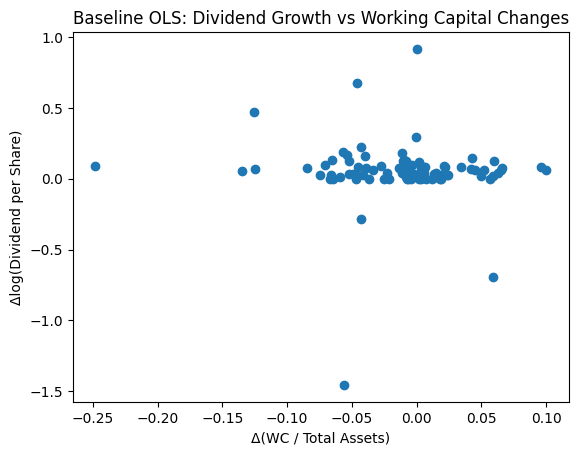

In [44]:
# =====================================================
# 0) INSTALL + IMPORTS
# =====================================================
import sys
!{sys.executable} -m pip install -q pandas openpyxl statsmodels numpy matplotlib

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path


# =====================================================
# 1) LOAD DATA (REG 2015–2019)
# =====================================================
FILE = Path("output") / "SECplusYahoo_RAW_REG_2015_2019_ML_2020_2024.xlsx"
SHEET = "REG_2015_2019"

df = pd.read_excel(FILE, sheet_name=SHEET)


df = df.sort_values(["Ticker", "Year"]).reset_index(drop=True)

# =====================================================
# 2) CONSTRUCTION OF VARIABLES
# =====================================================

# Working Capital and ratio
df["WorkingCapital"] = df["CurrentAssets"] - df["CurrentLiabilities"]
df["WC_to_TA"] = df["WorkingCapital"] / df["TotalAssets"]

# consecutive years 
df["year_gap"] = df.groupby("Ticker")["Year"].diff()

# log(DPS) only if DPS > 0
df["ln_dps"] = np.where(df["DPS_Annual"] > 0, np.log(df["DPS_Annual"]), np.nan)

# annual changes
df["dlog_dps"] = df.groupby("Ticker")["ln_dps"].diff()
df["dwc_ta"]   = df.groupby("Ticker")["WC_to_TA"].diff()

# keeping only consecutive observations
df_model = df[df["year_gap"] == 1].copy()

# dropping observation with misssing values required for the regressions
df_model = df_model.dropna(subset=["dlog_dps", "dwc_ta"]).copy()

print("Nombre d'observations utilisées :", df_model.shape[0])
print("Nombre d'entreprises :", df_model["Ticker"].nunique())

# =====================================================
# 3) REGRESSION OLS BASELINE
# Δlog(DPS) = α + β Δ(WC/TA) + ε
# clustering standard errors at the firm level
# =====================================================
Y = df_model["dlog_dps"]
X = sm.add_constant(df_model["dwc_ta"])

ols = sm.OLS(Y, X).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_model["Ticker"]}
)

print(ols.summary())

# =====================================================
# 4) TABLE OF RESULTS
# =====================================================
results_table = pd.DataFrame({
    "Coefficient": ols.params,
    "Std. Error (cluster firm)": ols.bse,
    "t-stat": ols.tvalues,
    "p-value": ols.pvalues
})



print("\n=== TABLE OF RESULTS ===")
print(results_table)

# =====================================================
# 5) GRAPH
# =====================================================
plt.figure()
plt.scatter(df_model["dwc_ta"], df_model["dlog_dps"])
plt.xlabel("Δ(WC / Total Assets)")
plt.ylabel("Δlog(Dividend per Share)")
plt.title("Baseline OLS: Dividend Growth vs Working Capital Changes")
plt.show()



In [45]:
# =====================================================
# 6) PANEL FIXED EFFECTS (BASELINE) - ULTRA ROBUSTE
# Uses numpy float arrays to avoid pandas dtype object issues
# =====================================================
import numpy as np
import statsmodels.api as sm

# 1) Construct X with dwc_ta + dummies firm
fe_dummies = pd.get_dummies(df_model["Ticker"], prefix="FE", drop_first=True)
X_fe = pd.concat([df_model[["dwc_ta"]], fe_dummies], axis=1)
X_fe = sm.add_constant(X_fe)

# 2) Force numeric types and drop missing values
X_fe = X_fe.apply(pd.to_numeric, errors="coerce")
Y_fe = pd.to_numeric(df_model["dlog_dps"], errors="coerce")

mask = (~Y_fe.isna()) & (~X_fe.isna().any(axis=1))
Y_fe_clean = Y_fe.loc[mask]
X_fe_clean = X_fe.loc[mask]
groups = df_model.loc[mask, "Ticker"]

print("Use observations included in the fixed-effects regressions :", len(Y_fe_clean), "| Firms :", groups.nunique())

# 3) Convert to NumPy float (critical to avoid dtype=object errors)
X_np = X_fe_clean.to_numpy(dtype=float)
Y_np = Y_fe_clean.to_numpy(dtype=float)

# 4) Fit FE
fe_model = sm.OLS(Y_np, X_np).fit(
    cov_type="cluster",
    cov_kwds={"groups": groups.to_numpy()}
)

# Extract the coefficient of dwc_ta (column 1 if the constant is column 0)
# To be safe, retrieve the exact index using column names
col_names = list(X_fe_clean.columns)
idx_dwc = col_names.index("dwc_ta")

beta_dwc = fe_model.params[idx_dwc]
se_dwc = fe_model.bse[idx_dwc]
p_dwc = fe_model.pvalues[idx_dwc]

print("\n=== FIXED EFFECTS (BASELINE) ===")
print("beta(dwc_ta) =", beta_dwc)
print("SE cluster   =", se_dwc)
print("p-value      =", p_dwc)

# resume
print("\nResume :")
print(fe_model.summary())


Use observations included in the fixed-effects regressions : 92 | Firms : 23

=== FIXED EFFECTS (BASELINE) ===
beta(dwc_ta) = -0.15119787813996183
SE cluster   = 0.5653512797092759
p-value      = 0.7891299531340655

Resume :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                 -0.089
Method:                 Least Squares   F-statistic:                   0.06456
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.802
Time:                        18:57:51   Log-Likelihood:                 17.428
No. Observations:                  92   AIC:                             13.14
Df Residuals:                      68   BIC:                             73.67
Df Model:                          23                                         
Covariance Type:              cluster                           

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [46]:
# =====================================================
# 6) PANEL FIXED EFFECTS (BASELINE) - ULTRA ROBUSTE + TABLEAU
# =====================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) X = const + dwc_ta + firm dummies
fe_dummies = pd.get_dummies(df_model["Ticker"], prefix="FE", drop_first=True)
X_fe = pd.concat([df_model[["dwc_ta"]], fe_dummies], axis=1)
X_fe = sm.add_constant(X_fe)

# 2) Force numeric types and drop missing values
X_fe = X_fe.apply(pd.to_numeric, errors="coerce")
Y_fe = pd.to_numeric(df_model["dlog_dps"], errors="coerce")

mask = (~Y_fe.isna()) & (~X_fe.isna().any(axis=1))
Y_fe_clean = Y_fe.loc[mask]
X_fe_clean = X_fe.loc[mask]
groups = df_model.loc[mask, "Ticker"]

print("# Use observations included in the fixed-effects regressions :", len(Y_fe_clean), "| Firms :", groups.nunique())

# 3)  Convert to NumPy float (critical to avoid dtype=object errors)
X_np = X_fe_clean.to_numpy(dtype=float)
Y_np = Y_fe_clean.to_numpy(dtype=float)
groups_np = groups.to_numpy()

# 4) Fit FE with SE cluster by firm
fe_model = sm.OLS(Y_np, X_np).fit(
    cov_type="cluster",
    cov_kwds={"groups": groups_np}
)

# 5) Table of coefficient
fe_table = pd.DataFrame({
    "coef": fe_model.params,
    "std_err(cluster)": fe_model.bse,
    "z": fe_model.tvalues,
    "p_value": fe_model.pvalues
}, index=X_fe_clean.columns)

print("\n=== TABLEAU FIXED EFFECTS (baseline) ===")
display(fe_table.loc[["const", "dwc_ta"]])   


# 6) Resume
print("\nResume :")
print(fe_model.summary())


# Use observations included in the fixed-effects regressions : 92 | Firms : 23

=== TABLEAU FIXED EFFECTS (baseline) ===


,coef,std_err(cluster),z,p_value
const,0.043138,0.002335,18.477163,3.153295e-76
dwc_ta,-0.151198,0.565351,-0.267441,7.891300e-01



Resume :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                 -0.089
Method:                 Least Squares   F-statistic:                   0.06456
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.802
Time:                        18:57:51   Log-Likelihood:                 17.428
No. Observations:                  92   AIC:                             13.14
Df Residuals:                      68   BIC:                             73.67
Df Model:                          23                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0431      0.002     18.47

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


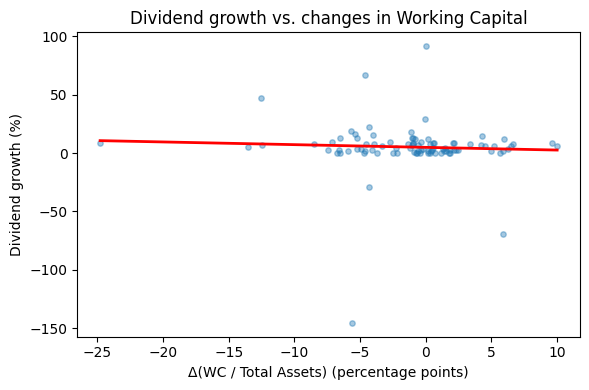

In [47]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

# Recréer df_model à partir des données REG
df_plot = reg_clean.copy()

# Construire les variables nécessaires si besoin
df_plot = df_plot.sort_values(["Ticker", "Year"])
df_plot["dwc_ta"] = df_plot.groupby("Ticker")["WC_to_TA"].diff()

df_plot["ln_dps"] = np.where(df_plot["DPS_Annual"] > 0,
                             np.log(df_plot["DPS_Annual"]),
                             np.nan)
df_plot["dlog_dps"] = df_plot.groupby("Ticker")["ln_dps"].diff()

# Drop NA
df_plot = df_plot.dropna(subset=["dwc_ta", "dlog_dps"])

# Axes (en pourcentage)
x_pp = df_plot["dwc_ta"] * 100
y_percent = df_plot["dlog_dps"] * 100

# Droite de tendance
b1, b0 = np.polyfit(x_pp, y_percent, 1)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(x_pp, y_percent, alpha=0.4, s=15)
plt.plot(np.sort(x_pp), b1*np.sort(x_pp) + b0, color="red", linewidth=2)

plt.xlabel("Δ(WC / Total Assets) (percentage points)")
plt.ylabel("Dividend growth (%)")
plt.title("Dividend growth vs. changes in Working Capital")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "fig1_wc_dividend_regression.png",
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()




In [48]:
# =====================================================
# 7) COMPREHENSIVE MODEL — PANEL FIXED EFFECTS (WITHOUT WC)
# Δlog(DPS) = ROA + Leverage + Size + firm FE + ε
# =====================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------
# 1) Build variables
# -----------------------------

df_comp = df_model.copy()

# ROA
df_comp["ROA"] = df_comp["NetIncome"] / df_comp["TotalAssets"]

# Leverage
df_comp["Leverage"] = df_comp["TotalLiabilities"] / df_comp["TotalAssets"]

# Size = log(Total Assets)
df_comp["Size"] = np.log(df_comp["TotalAssets"])

# -----------------------------
# 2) Prepare X and Y
# -----------------------------

Y = pd.to_numeric(df_comp["dlog_dps"], errors="coerce")

X_controls = df_comp[["ROA", "Leverage", "Size"]]

# Firm fixed effects (dummies)
fe_dummies = pd.get_dummies(df_comp["Ticker"], prefix="FE", drop_first=True)

X = pd.concat([X_controls, fe_dummies], axis=1)
X = sm.add_constant(X)

# Enforce numeric types
X = X.apply(pd.to_numeric, errors="coerce")

# Drop missing values (safety)
mask = (~Y.isna()) & (~X.isna().any(axis=1))
Y_clean = Y.loc[mask]
X_clean = X.loc[mask]
groups = df_comp.loc[mask, "Ticker"]

print("Obs utilisées :", len(Y_clean))
print("Firms :", groups.nunique())

# -----------------------------
# 3) Estimation FE (numpy float)
# -----------------------------

X_np = X_clean.to_numpy(dtype=float)
Y_np = Y_clean.to_numpy(dtype=float)
groups_np = groups.to_numpy()

fe_comp_no_wc = sm.OLS(Y_np, X_np).fit(
    cov_type="cluster",
    cov_kwds={"groups": groups_np}
)

# -----------------------------
# 4) TABLE OF RESULTS
# -----------------------------

results_no_wc = pd.DataFrame({
    "Coefficient": fe_comp_no_wc.params,
    "Std. Error (cluster firm)": fe_comp_no_wc.bse,
    "t-stat": fe_comp_no_wc.tvalues,
    "p-value": fe_comp_no_wc.pvalues
}, index=X_clean.columns)

print("\n=== COMPREHENSIVE FE (without WORKING CAPITAL) ===")
display(results_no_wc.loc[["const", "ROA", "Leverage", "Size"]])

# Resume
print("\nResume :")
print(fe_comp_no_wc.summary())


Obs utilisées : 92
Firms : 23

=== COMPREHENSIVE FE (without WORKING CAPITAL) ===


,Coefficient,Std. Error (cluster firm),t-stat,p-value
const,3.308465,3.160543,1.046802,0.295191
ROA,0.264667,0.333853,0.792764,0.427915
Leverage,-0.069123,0.220483,-0.313506,0.753896
Size,-0.149636,0.141379,-1.058403,0.289872



Resume :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                     2.321
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.103
Time:                        18:57:51   Log-Likelihood:                 18.533
No. Observations:                  92   AIC:                             14.93
Df Residuals:                      66   BIC:                             80.50
Df Model:                          25                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3085      3.161      1.04

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [49]:
# =====================================================
# 8) COMPREHENSIVE MODEL — PANEL FIXED EFFECTS (AVEC WC)
# Δlog(DPS) = Δ(WC/TA) + ROA + Leverage + Size + firm FE + ε
# =====================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------
# 1) Build WC variable
# -----------------------------

df_full = df_comp.copy()

# Δ(WC/TA) already computed
df_full["dwc_ta"] = df_model["dwc_ta"]

# -----------------------------
# 2) Prepare X and Y
# -----------------------------

Y = pd.to_numeric(df_full["dlog_dps"], errors="coerce")

X_vars = df_full[["dwc_ta", "ROA", "Leverage", "Size"]]

# Firm fixed effects
fe_dummies = pd.get_dummies(df_full["Ticker"], prefix="FE", drop_first=True)

X = pd.concat([X_vars, fe_dummies], axis=1)
X = sm.add_constant(X)

# Enforce numeric types
X = X.apply(pd.to_numeric, errors="coerce")

# Drop missing value (safety)
mask = (~Y.isna()) & (~X.isna().any(axis=1))
Y_clean = Y.loc[mask]
X_clean = X.loc[mask]
groups = df_full.loc[mask, "Ticker"]

print("Obs utilisées :", len(Y_clean))
print("Firmes :", groups.nunique())

# -----------------------------
# 3) Estimation FE (robust)
# -----------------------------

X_np = X_clean.to_numpy(dtype=float)
Y_np = Y_clean.to_numpy(dtype=float)
groups_np = groups.to_numpy()

fe_comp_wc = sm.OLS(Y_np, X_np).fit(
    cov_type="cluster",
    cov_kwds={"groups": groups_np}
)

# -----------------------------
# 4) Table of results
# -----------------------------

results_wc = pd.DataFrame({
    "Coefficient": fe_comp_wc.params,
    "Std. Error (cluster firm)": fe_comp_wc.bse,
    "t-stat": fe_comp_wc.tvalues,
    "p-value": fe_comp_wc.pvalues
}, index=X_clean.columns)

print("\n=== COMPREHENSIVE FE (WITH WORKING CAPITAL) ===")
display(results_wc.loc[["const", "dwc_ta", "ROA", "Leverage", "Size"]])

# (optionnel) résumé complet
print("\nResume :")
print(fe_comp_wc.summary())


Obs utilisées : 92
Firmes : 23

=== COMPREHENSIVE FE (WITH WORKING CAPITAL) ===


,Coefficient,Std. Error (cluster firm),t-stat,p-value
const,3.363637,3.028606,1.110622,0.266731
dwc_ta,-0.159999,0.547571,-0.292198,0.770136
ROA,0.225317,0.435395,0.517500,0.604807
Leverage,-0.074209,0.207833,-0.357063,0.721045
Size,-0.152046,0.135517,-1.121970,0.261875



Resume :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                     1.749
Date:                Tue, 06 Jan 2026   Prob (F-statistic):              0.175
Time:                        18:57:51   Log-Likelihood:                 18.597
No. Observations:                  92   AIC:                             16.81
Df Residuals:                      65   BIC:                             84.89
Df Model:                          26                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3636      3.029      1.11

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 26, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [50]:
# =====================================================
# FE BASELINE — WC ALONE (for table)
# =====================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Y
Y = pd.to_numeric(df_model["dlog_dps"], errors="coerce")

# X = dwc_ta + firm FE
X_vars = df_model[["dwc_ta"]]
fe_dummies = pd.get_dummies(df_model["Ticker"], prefix="FE", drop_first=True)

X = pd.concat([X_vars, fe_dummies], axis=1)
X = sm.add_constant(X)
X = X.apply(pd.to_numeric, errors="coerce")

# Drop missing value
mask = (~Y.isna()) & (~X.isna().any(axis=1))
Y_clean = Y.loc[mask]
X_clean = X.loc[mask]
groups = df_model.loc[mask, "Ticker"]

# numpy arrays (robust)
X_np = X_clean.to_numpy(dtype=float)
Y_np = Y_clean.to_numpy(dtype=float)
groups_np = groups.to_numpy()

# Estimation FE baseline
fe_baseline = sm.OLS(Y_np, X_np).fit(
    cov_type="cluster",
    cov_kwds={"groups": groups_np}
)

print("FE baseline estimé.")
print("Obs :", fe_baseline.nobs)


FE baseline estimé.
Obs : 92.0


In [51]:
import sys
!{sys.executable} -m pip install jinja2


1452.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [52]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

try:
    from IPython.display import display
except Exception:
    display = print

# =====================================================
# 1) Load the file generated by the data-collection script
# =====================================================
path = "output/SECplusYahoo_RAW_REG_2015_2019_ML_2020_2024.xlsx"
df = pd.read_excel(path, sheet_name="REG_2015_2019")

# =====================================================
# 2) Build variable (if needed)
# =====================================================
df = df.sort_values(["Ticker", "Year"])
df["dwc_ta"] = df.groupby("Ticker")["WC_to_TA"].diff()
df["Size"] = np.log(df["TotalAssets"].where(df["TotalAssets"] > 0))

# =====================================================
# 3) Panel index
# =====================================================
df = df.set_index(["Ticker", "Year"]).sort_index()

# =====================================================
# 4) FE regressions
# =====================================================
def fe(y, x):
    d = df[[y] + x].dropna()
    mod = PanelOLS(d[y], d[x], entity_effects=True)
    return mod.fit(cov_type="clustered", cluster_entity=True)

Y = "DPS_Annual"

m1 = fe(Y, ["dwc_ta"])
m2 = fe(Y, ["ROA", "Leverage", "Size"])
m3 = fe(Y, ["dwc_ta", "ROA", "Leverage", "Size"])

# =====================================================
# 5) Final table
# =====================================================
def coef(model, var):
    if var in model.params.index:
        return f"{model.params[var]:.3f} ({model.std_errors[var]:.3f})"
    return ""

table = pd.DataFrame({
    "(1) Baseline FE\nWC only": {
        "Δ(WC/TA)": coef(m1, "dwc_ta"),
        "ROA": "",
        "Leverage": "",
        "Size": "",
    },
    "(2) Comprehensive FE\nNo WC": {
        "Δ(WC/TA)": "",
        "ROA": coef(m2, "ROA"),
        "Leverage": coef(m2, "Leverage"),
        "Size": coef(m2, "Size"),
    },
    "(3) Comprehensive FE\nWith WC": {
        "Δ(WC/TA)": coef(m3, "dwc_ta"),
        "ROA": coef(m3, "ROA"),
        "Leverage": coef(m3, "Leverage"),
        "Size": coef(m3, "Size"),
    }
})

info = pd.DataFrame({
    "(1) Baseline FE\nWC only": ["Yes", "Firm clustered", int(m1.nobs)],
    "(2) Comprehensive FE\nNo WC": ["Yes", "Firm clustered", int(m2.nobs)],
    "(3) Comprehensive FE\nWith WC": ["Yes", "Firm clustered", int(m3.nobs)],
}, index=["Firm Fixed Effects", "SE", "Observations"])

final_table = pd.concat([table, info])

display(final_table)

# Export table
final_table.to_excel(FIGURES_DIR / "final_dividend_regression_table.xlsx")
print("✅ Exported :", FIGURES_DIR / "final_dividend_regression_table.xlsx")

with open(FIGURES_DIR / "table_fe.tex", "w") as f:
    f.write(final_table.to_latex(
        index=True,
        escape=False,
        column_format="lccc"
    ))

print("✅ Exported :", FIGURES_DIR / "table_fe.tex")




,(1) Baseline FE\nWC only,(2) Comprehensive FE\nNo WC,(3) Comprehensive FE\nWith WC
Δ(WC/TA),-1.095 (0.627),,-1.062 (0.578)
ROA,,0.394 (1.092),0.182 (0.862)
Leverage,,0.117 (0.153),-0.012 (0.185)
Size,,0.318 (0.142),0.238 (0.114)
Firm Fixed Effects,Yes,Yes,Yes
SE,Firm clustered,Firm clustered,Firm clustered
Observations,92,115,92


✅ Exported : figures/final_dividend_regression_table.xlsx
✅ Exported : figures/table_fe.tex


In [53]:

!{sys.executable} -m pip install -q pandas openpyxl numpy scikit-learn statsmodels

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# -----------------------------
# 1) LOAD RAW DATA
# -----------------------------
FILE = Path("output") / "SECplusYahoo_RAW_REG_2015_2019_ML_2020_2024.xlsx"  
SHEET = "RAW_2015_2024"

df = pd.read_excel(FILE, sheet_name=SHEET)
df = df.sort_values(["Ticker", "Year"]).reset_index(drop=True)

print("RAW shape:", df.shape, "| Firms:", df["Ticker"].nunique(), "| Years:", df["Year"].min(), "-", df["Year"].max())

# -----------------------------
# 2) BUILD BASE VARIABLES
# -----------------------------
# Working capital ratio
df["WorkingCapital"] = df["CurrentAssets"] - df["CurrentLiabilities"]
df["WC_to_TA"] = df["WorkingCapital"] / df["TotalAssets"]

# Fundamentals
df["ROA"] = df["NetIncome"] / df["TotalAssets"]
df["Leverage"] = df["TotalLiabilities"] / df["TotalAssets"]
df["Size"] = np.log(df["TotalAssets"])

# Target: dlog_dps
df["ln_dps"] = np.where(df["DPS_Annual"] > 0, np.log(df["DPS_Annual"]), np.nan)
df["dlog_dps"] = df.groupby("Ticker")["ln_dps"].diff()

# ΔWC/TA (contemporaneous change)
df["dwc_ta"] = df.groupby("Ticker")["WC_to_TA"].diff()

# consecutive year check
df["year_gap"] = df.groupby("Ticker")["Year"].diff()

# Keep only rows where change is year-to-year (no gaps)
df = df[df["year_gap"] == 1].copy()

# -----------------------------
# 3) CREATE LAGGED FEATURES (use t-1 info to predict dlog_dps at t)
# -----------------------------
# For each firm-year t, use values from t-1 as predictors
for col in ["ROA", "Leverage", "Size", "WC_to_TA", "dwc_ta"]:
    df[col + "_lag1"] = df.groupby("Ticker")[col].shift(1)

# Our prediction target is dlog_dps at year t
# We require lag features not missing
needed = ["dlog_dps", "ROA_lag1", "Leverage_lag1", "Size_lag1", "dwc_ta_lag1"]
df_model = df.dropna(subset=needed).copy()

print("Model-ready rows:", df_model.shape[0], "| Firms:", df_model["Ticker"].nunique())
print("Years in model-ready:", sorted(df_model["Year"].unique()))

# -----------------------------
# 4) TEMPORAL SPLIT 
# Train years: <= 2020 (targets 2016-2020 typically)
# Test years : 2021-2024
# -----------------------------
train = df_model[df_model["Year"] <= 2020].copy()
test  = df_model[(df_model["Year"] >= 2021) & (df_model["Year"] <= 2024)].copy()

print("Train rows:", train.shape[0], "| Test rows:", test.shape[0])
print("Train years:", sorted(train["Year"].unique()))
print("Test years:", sorted(test["Year"].unique()))

# Keep only firms present in both (important for FE prediction)
common_firms = sorted(set(train["Ticker"]).intersection(set(test["Ticker"])))
train = train[train["Ticker"].isin(common_firms)].copy()
test  = test[test["Ticker"].isin(common_firms)].copy()
print("Common firms:", len(common_firms), "| Train rows:", train.shape[0], "| Test rows:", test.shape[0])

y_train = train["dlog_dps"].to_numpy()
y_test  = test["dlog_dps"].to_numpy()

# -----------------------------
# 5) RANDOM FOREST (A) Controls only vs (B) + Working Capital
# Using lagged features to avoid leakage
# -----------------------------
Xcols_A = ["ROA_lag1", "Leverage_lag1", "Size_lag1"]
Xcols_B = ["dwc_ta_lag1", "ROA_lag1", "Leverage_lag1", "Size_lag1"]

X_train_A = train[Xcols_A].to_numpy()
X_test_A  = test[Xcols_A].to_numpy()

X_train_B = train[Xcols_B].to_numpy()
X_test_B  = test[Xcols_B].to_numpy()

rf_params = dict(
    n_estimators=500,
    random_state=42,
    min_samples_leaf=2,
    n_jobs=-1
)

rf_A = RandomForestRegressor(**rf_params).fit(X_train_A, y_train)
rf_B = RandomForestRegressor(**rf_params).fit(X_train_B, y_train)

pred_A = rf_A.predict(X_test_A)
pred_B = rf_B.predict(X_test_B)

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_A, mae_A, r2_A = metrics(y_test, pred_A)
rmse_B, mae_B, r2_B = metrics(y_test, pred_B)

ml_summary = pd.DataFrame({
    "Model": ["RF Controls only (lagged)", "RF Controls + Δ(WC/TA)_lag1"],
    "RMSE": [rmse_A, rmse_B],
    "MAE": [mae_A, mae_B],
    "R2_out_of_sample": [r2_A, r2_B],
    "Train_rows": [len(train), len(train)],
    "Test_rows": [len(test), len(test)]
})

print("\n=== ML PERFORMANCE (Temporal split) ===")
print(ml_summary)

imp_A = pd.DataFrame({"feature": Xcols_A, "importance": rf_A.feature_importances_}).sort_values("importance", ascending=False)
imp_B = pd.DataFrame({"feature": Xcols_B, "importance": rf_B.feature_importances_}).sort_values("importance", ascending=False)

print("\n=== Feature importance A ===")
print(imp_A)
print("\n=== Feature importance B ===")
print(imp_B)

# -----------------------------
# 6) ECONOMETRIC PREDICTION 
# (i) Pooled OLS on train -> predict test
# (ii) Firm FE on train -> predict test (for same firms)
# -----------------------------

# --- (i) Pooled OLS (controls + WC lag1) ---
Y_tr = train["dlog_dps"].to_numpy()
X_tr = sm.add_constant(train[["dwc_ta_lag1","ROA_lag1","Leverage_lag1","Size_lag1"]]).to_numpy(dtype=float)

ols_tr = sm.OLS(Y_tr, X_tr).fit()
X_te = sm.add_constant(test[["dwc_ta_lag1","ROA_lag1","Leverage_lag1","Size_lag1"]]).to_numpy(dtype=float)
pred_ols = ols_tr.predict(X_te)

rmse_ols, mae_ols, r2_ols = metrics(y_test, pred_ols)

# --- (ii) Firm Fixed Effects on train (dummies), then predict on test ---
# Build design matrices with identical columns
def build_fe_matrix(data, firm_list, include_wc=True):
    base = ["ROA_lag1","Leverage_lag1","Size_lag1"]
    if include_wc:
        base = ["dwc_ta_lag1"] + base

    X0 = data[base].copy()
    dums = pd.get_dummies(data["Ticker"], prefix="FE")
    # ensure all firms columns exist
    for f in firm_list:
        col = f"FE_{f}"
        if col not in dums.columns:
            dums[col] = 0
    dums = dums[[f"FE_{f}" for f in firm_list]]
    # drop one dummy to avoid collinearity
    dums = dums.drop(columns=[f"FE_{firm_list[0]}"])
    X = pd.concat([X0, dums], axis=1)
    X = sm.add_constant(X)
    return X

firm_list = common_firms[:]  # same firms in train & test

X_fe_tr = build_fe_matrix(train, firm_list, include_wc=True).to_numpy(dtype=float)
Y_fe_tr = train["dlog_dps"].to_numpy(dtype=float)

fe_tr = sm.OLS(Y_fe_tr, X_fe_tr).fit()

X_fe_te = build_fe_matrix(test, firm_list, include_wc=True).to_numpy(dtype=float)
pred_fe = fe_tr.predict(X_fe_te)

rmse_fe, mae_fe, r2_fe = metrics(y_test, pred_fe)

econ_pred = pd.DataFrame({
    "Model": ["Pooled OLS (lagged, train->test)", "Firm FE (lagged, train->test)"], 
    "RMSE": [rmse_ols, rmse_fe],
    "MAE": [mae_ols, mae_fe],
    "R2_out_of_sample": [r2_ols, r2_fe],
    "Train_years": ["<=2020", "<=2020"],
    "Test_years": ["2021-2024", "2021-2024"]
})

print("\n=== ECONOMETRIC PREDICTION (Temporal split) ===")
print(econ_pred)


1457.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


RAW shape: (870, 9) | Firms: 87 | Years: 2015 - 2024
Model-ready rows: 248 | Firms: 37
Years in model-ready: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Train rows: 114 | Test rows: 134
Train years: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]
Test years: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Common firms: 32 | Train rows: 110 | Test rows: 121

=== ML PERFORMANCE (Temporal split) ===
                         Model      RMSE       MAE  R2_out_of_sample  \
0    RF Controls only (lagged)  0.507165  0.207216         -0.141883   
1  RF Controls + Δ(WC/TA)_lag1  0.544684  0.258031         -0.317079   

   Train_rows  Test_rows  
0         110        121  
1         110        121  

=== Feature importance A ===
         feature  importance
1  Leverage_lag1    0.476933
2      Size_lag1    0.307342
0       ROA_lag1    0.215725

=== Feature importance B ===
       

In [54]:
import sys
!{sys.executable} -m pip install linearmodels


1464.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [55]:
print(type(ml_summary))
display(ml_summary)


<class 'pandas.core.frame.DataFrame'>


,Model,RMSE,MAE,R2_out_of_sample,Train_rows,Test_rows
0,RF Controls only (lagged),0.507165,0.207216,-0.141883,110,121
1,RF Controls + Δ(WC/TA)_lag1,0.544684,0.258031,-0.317079,110,121


In [56]:
with open(FIGURES_DIR / "table_pred.tex", "w") as f:
    f.write(econ_pred.to_latex(index=False, escape=False))

print("✅ Exporté :", FIGURES_DIR / "table_pred.tex")


✅ Exporté : figures/table_pred.tex


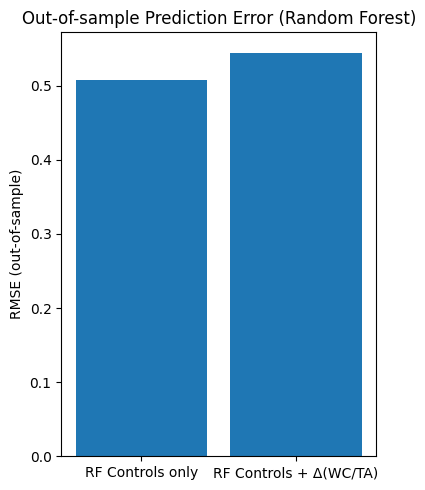

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["RF Controls only", "RF Controls + Δ(WC/TA)"]
rmse_values = [0.507165, 0.544684]

# Positions for bars
x = np.arange(len(models))

plt.figure(figsize=(4, 5))  # taille plus compacte

# Thin bars
plt.bar(x, rmse_values, width=0.85)

# Labels
plt.xticks(x, models, rotation=0)
plt.ylabel("RMSE (out-of-sample)")
plt.title("Out-of-sample Prediction Error (Random Forest)")

# Clean layout
plt.tight_layout()

# Save for Overleaf
plt.savefig(FIGURES_DIR / "fig2_rf_rmse_comparison.png",
            dpi=300, bbox_inches="tight")

plt.show()
plt.close()
